<a href="https://colab.research.google.com/github/heesukjang/W266_NLP_With_DeepLearning/blob/main/Final_Project/BERTTweet_3_20_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notes from Natalie's OH (3/15):
- Low accuracy and high loss (between 0.25 and 0.40) are acceptable in the baseline (freeze all the layers) as we are dealing with many labels (9 classes for each of the 6 analytic metrics)
  - Random guess of our accuracy is 1/9 = **0.11** (9 classes) and the results (between 0.25 and 0.40) are higher than the random guess. That means our model is learning something but the accuracy won't be really high again due to so many classes (9 classes) we need to generate the correct predictions from.
  - After unfreeze all the 12 layers, the accuracy improved about 10-15%. That considered to be pretty good understanding we have 9 classes.
- Possible ways to increase performance results:
  - increase size of the training data
  - **fine-tuning (ensure to avoid overfitting issue)**:
    - num of layers to unfreeze
    - num of hidden layers
    - learning rate
    - diff optimizer
    - num of epochs (EarlyStopping)
    - (not necessary as we deal with limited computational resources - takes a lot of resources to hyperparameter tuning with transformer-based models) **hyperparam tuning** (in order to do this, we need to split the given training set into train/valid/test. because we are in general apply hyper param tuning on validation set)
- As using the black box pre-trained models like BERT and derived BERT(i.e. BERTTweet and RetriBERT), we want to pass the text input data into the model as is (i.e. if there is a hashtag in student essays, that might indicate not well-written. Those black box models (large language models) are pretty advanced and sophisticated that typically very little or no preprocessing input text is needed. They can handle all of that complexity in text (i.e. if there are special chars seen like messy text from a web, the model automatically ignore them as they don't add any values in analysis) 
  - POS tagging ? => not needed
  - ngram LPM ? => not needed
  - Lemmitization/stemming etc? => not needed

- For the **imbalanced** data like ours, the breakdowns to 9 classes will be very much helpful. In general we could try to balance by under-sample the over-represented classes or over-sample the under-represented (less common) classes. However having a small data under 4000 (split into training/valid/test in 80%/10%/10%(3120/390/390)), we might not want to do so becasue of the risk of overfitting for certain examples. Instead we want to pass [sample_weight or class_weight](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data) as a **dictionary** in each 6 classification layer in the keras model. In this way it will still only learn each example one time with an epoch (이팍) but in the loss function, it will put more weight on the ones that are needed to learn more from. The goal of that is not overpredicting more common classes. This is the reason we want to breakdown the evaluation scores like **precision, recall, and F1 Score** in each class level (레블) as you want to see **confusion matrix** and **classification report**. You want to see that it might be predicting 2s and 3s when it should be 1 or 5. 
  - (This will be interesting analysis) Likely to get much higher accuracy scores like 60% and 70% for the largly represented labels (like 2.5 and 3.5) while getting rare extreme scores for less common labels like 1 and 5.




## **Srila's rounded classes:** appear to be rounded down instead of up

In [4]:
# # Scaling by total/2 helps keep the loss to a similar magnitude.
# # The sum of the weights of all examples stays the same.
# weight_for_0 = (1 / neg) * (total / 2.0)
# weight_for_1 = (1 / pos) * (total / 2.0)

# class_weight = {0: weight_for_0, 1: weight_for_1}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))

## Baseline: A baseline BERT for the Text Classification
**Heesuk Jang**<br>
Spring 2023<br>


**(Srila's Note)** To set up a BERT model for a classification task using essays as an input, you can follow these general steps:

1. Data preprocessing: Preprocess the essays by tokenizing them into individual words and applying any necessary cleaning or normalization techniques.

2. Data splitting: Split the preprocessed essays into training, validation, and test sets.

3. Model architecture: Choose a pre-trained BERT model (e.g., BERT base, BERT large) and adapt it for your classification task by adding a classification layer on top of the BERT output.

4. Fine-tuning: Fine-tune the pre-trained BERT model on the training set by minimizing a suitable loss function. During fine-tuning, the weights of the BERT model will be updated to better fit the specific classification task.

5. Evaluation: Evaluate the fine-tuned model on the validation set to tune any hyperparameters (e.g., learning rate, number of epochs). After finalizing the hyperparameters, evaluate the model on the test set to obtain the final performance metrics.

6. Inference: Use the trained BERT model to predict the classification label for new essays by passing them through the preprocessed and fine-tuned model.

There are many libraries and frameworks available to help you set up a BERT model for classification tasks, such as Hugging Face's Transformers library in Python. You can find many tutorials and code examples online to help you get started.

In [5]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install transformers
!pip install wordcloud
!pip install nltk
!pip3 install emoji==0.6.0
# !pip install emoji --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.27.2-py3-none-any.whl (6.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import transformers
print(f'transformers version: {transformers.__version__}')
from transformers import logging as hf_logging
hf_logging.set_verbosity_error()

transformers version: 4.27.2


In [7]:
import nltk
import spacy      
from spacy import displacy
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from wordcloud import ImageColorGenerator
import sys
import math
import emoji

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.layer_utils import count_params
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Multiply
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import PReLU
from keras.layers.core import Activation
from keras.layers.convolutional import SeparableConv1D
from keras.layers.convolutional import SeparableConv2D
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.densenet import *
from keras.applications.resnet import ResNet152
from keras.applications.nasnet import NASNetMobile
from keras.applications.nasnet import NASNetLarge
from keras.applications.efficientnet import EfficientNetB7
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.nasnet import preprocess_input
from keras.applications import MobileNetV2
from keras.applications.xception import Xception
from keras.applications.inception_v3 import *

from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import save_img

from tensorflow.python.ops.numpy_ops import np_config

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler

from tensorflow.keras.losses import mae
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy

from keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Natalie's Suggestions on 3/1/2023 ([Summary Note](https://docs.google.com/document/d/16zREoA3Wuc1XTcqzjT9G8WrtgrHbV8hWVJmTjDN1tDk/edit#heading=h.rz6xb4lophqd)) with TODO Items
- Train set split into 80:20 train and validation set 
- Possible **Data Preprocessing**:
  - Essay **tokenization** using pre-trained model
  - **Stopwords** removal
  - **[Lemmitization](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/?ref=rp)/[Stemming](https://www.geeksforgeeks.org/python-stemming-words-with-nltk/?ref=rp)**
  - **[N-gram](https://www.geeksforgeeks.org/n-gram-language-modelling-with-nltk/) Language Model**
  - **[Part of Speech (POS)](https://towardsdatascience.com/visualizing-part-of-speech-tags-with-nltk-and-spacy-42056fcd777e)**: a technique used in NLP that categorizes the tokens in a text as nouns, verbs, adjectives, and so on.
    
    - [SpaCy](https://towardsdatascience.com/visualizing-part-of-speech-tags-with-nltk-and-spacy-42056fcd777e) comes with a visualizer called displaCy. E.g., you can render the POS tags and syntactic dependencies as follows with style = "dep".
- **<font color=red>(DONE)</font>** Correlation study between bucket of < 500 or > 500 word count and each metric score => BERT take the **max_length upto 512**
- Experiment with **Max Length of Tokens** to build BERT based on the result of the correlation study above. 
  - **<font color=red>(DONE)</font>** Apply **max_length = 500** for each essay if the word_count does not show a high correlation with the metrics.
  - Apply **max_length <= 500** for each subset of an essay if word count of an essay is greater than 500. 
    - Split each essay by the defined max length into multiple essays and get separate independent scores and average them to generate a single score
- Two diff approaches to build a baseline **BERT as a multi-label multiclass classification model**:
  - **<font color=red>(DONE)</font>** Build a single model for each metric (6 different models) with all the raw 9 metrics with 0.5 increment in scores OR
    - Multiclass (9 classes): 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, and 5
    - Each metric won't be tied together in any way so each model learns how to predict score in each metric as 6 separate problems, without realizing that there is some structure (i.e. ****
    - **<font color=red>(DONE)</font>** Pass CLS token layer as an input embedding to our classification model
    - As our labels are numeric so we may consider to build an **oridinal logistic regression (ORL)** as an output model for the 9 raw labels (i.e. 1, 1.5....4.5, 5). This means the structure of our model would be:
      - **Input embeddings** from <font color=blue>BERT</font>
      - Predicted **output score (label)** from <font color=blue>ORL</font>
  - Build a single model for all 6 metrics (i.e. cohesion, vocab, grammar, etc.)
- Evaluation Metrics for Text Classification (BLEU or ROUGE scores are only for **text generation** so they don't apply to our project):
  - Accuracy
  - Precision
  - Recall
  - F1 Score
- **Fine-Tuning** for the Advanced BERT and BERT derived Models:
  - Experiment with unfreezing different number of layers in the pre-trained models. Get the comparative results on performance but as a rule of thumb, unfreezing all the layers brings the best results without the overfitting issue.

## About Our Data - [Feedback Prize English (Universal Sentence Encoder)](https://www.kaggle.com/code/mrscofield/feedback-prize-english-universal-sentence-encoder)
The goal is to assess the language proficiency of 8th-12th grade English Language Learners (ELLs). Utilizing a dataset of essays written by ELLs will help to develop proficiency models that better supports all students.

This will help ELLs receive more accurate feedback on their language development and expedite the grading cycle for teachers. These outcomes could enable ELLs to receive more appropriate learning tasks that will help them improve their English language proficiency.

The dataset presented here (the ELLIPSE corpus) comprises argumentative essays written by 8th-12th grade English Language Learners (ELLs). The essays have been scored according to six analytic measures: **cohesion, syntax, vocabulary, phraseology, grammar, and conventions.**

Each measure represents a component of proficiency in essay writing, with greater scores corresponding to greater proficiency in that measure. The scores range from **1.0 to 5.0 in increments of 0.5**. The task is to predict the score of each of the six measures for the essays given in the test set.

**[MCRMSE (Mean columnwise root mean squared error)](https://stats.stackexchange.com/questions/487038/what-is-mcrmse-mean-columnwise-root-mean-squared-error)**:<br>The MCRMSE is simply an average across all RMSE values for each of our columns (metrics), so we can still use a single-number evaluation metric, even in the case of multiple outputs.

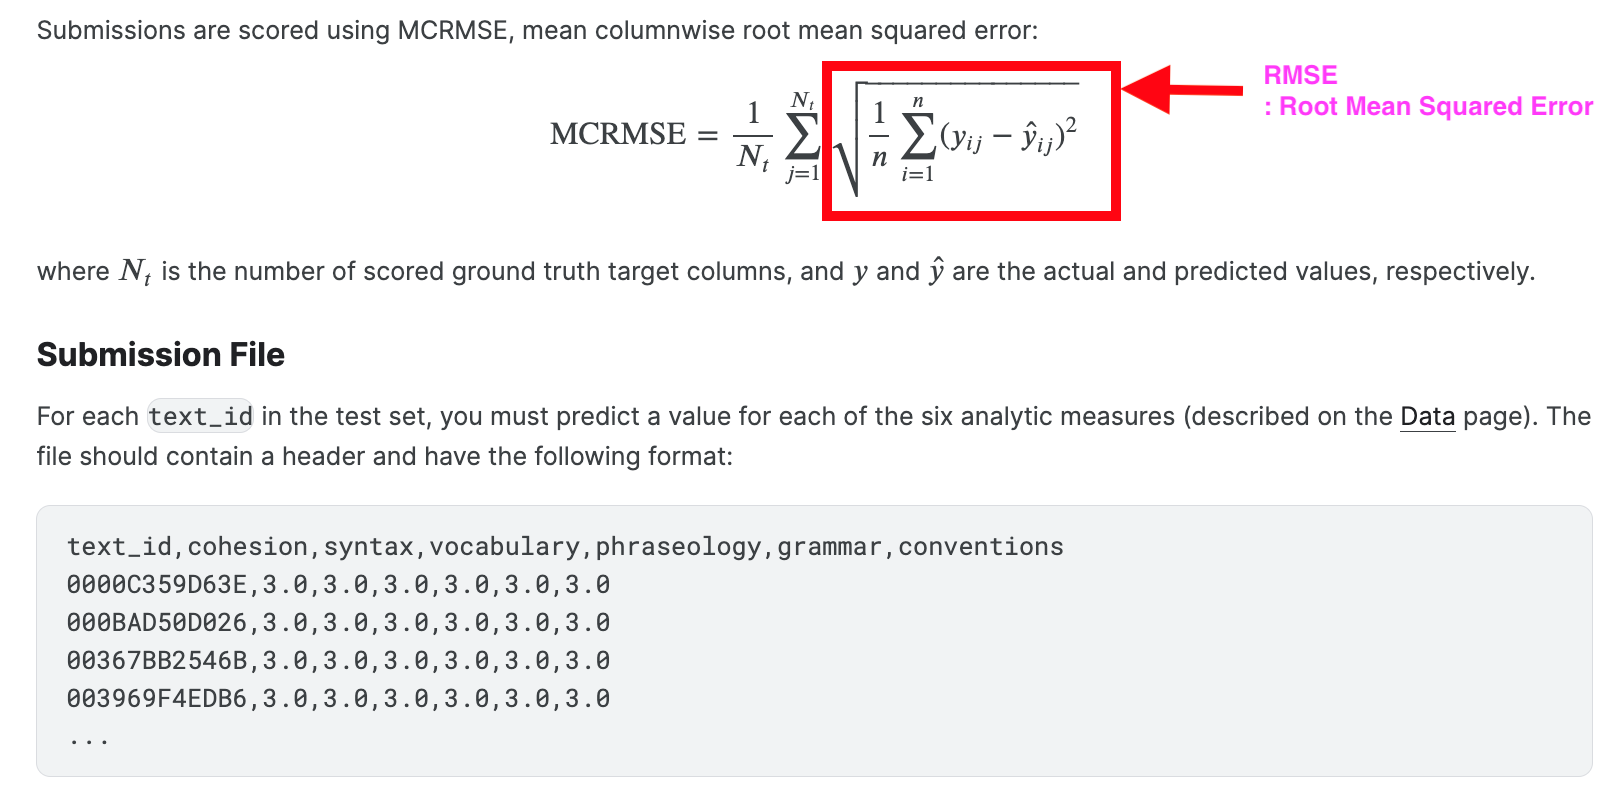


## Load and View Data

In [8]:
train_path = '/content/gdrive/MyDrive/Kaggle/train.csv'
test_path = '/content/gdrive/MyDrive/Kaggle/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

Generally, the training and validation data set is split into an 80:20 ratio. Thus, 20% of the data is set aside for validation purposes. The ratio changes based on the size of the data.

In [9]:
train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [10]:
test_df.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


## Create Features:
- **word_count**
- **char_len**
- **avg_score**
- **total_score**
- Categorical Target Labels: 
  - **9 Integer-type labels** from 0 to 8 replacing the given float scores
  - **5 Integer-type labels** from 1 to 5 replacing the given float scores

In [11]:
# import math
# print(math.ceil(2.5))
# print(math.ceil(2.3))
# print(math.ceil(2.7))
# print()
# print(np.round(2.5))
# print(np.round(2.3))
# print(np.round(2.7))
# print()
# print(round(2.5,0))
# print(round(2.3,0))
# print(round(2.7,0))
# print()
# print(int(2.5))
# print(int(2.3))
# print(int(2.7))
# print()
# print(np.ceil(2.5))
# print(np.ceil(2.3))
# print(np.ceil(2.7))
# print(np.ceil(3.0))

In [12]:
target_cols = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

def generate_features(df):
  df['word_count'] = df['full_text'].apply(lambda x: len(x.split()))
  df['char_len'] = df['full_text'].apply(lambda x: len(x))
  df['avg_score'] = df[target_cols].mean(axis=1).round(1)
  df['total_score'] = df[target_cols].sum(axis=1)

  key_float_labels, value_int_labels = np.arange(1, 5.5, 0.5), np.arange(9)
  dict_target_labels = dict(zip(key_float_labels, value_int_labels))
  
  for i in range(len(target_cols)):
    df[target_cols[i] + '_sparse_class'] = df[target_cols[i]].map(dict_target_labels)       # generate 9 integer classes: 0 - 8
    df[target_cols[i] + '_dense_class'] = df[target_cols[i]].apply(np.ceil).astype(int)     # generate 5 integer classes: 1 - 5
    # df[target_cols[i] + '_dense_class'] = np.round(df[target_cols[i]])             
  return df

train_df = generate_features(train_df)

In [13]:
dense_class_cols = [col for col in train_df.columns if 'dense_class' in col ]
sparse_class_cols = [col for col in train_df.columns if 'sparse_class' in col ]

print(f'Columns with sparse classes = {sparse_class_cols}\nColumns with dense classes = {dense_class_cols}\n')
print((train_df['word_count'].describe().round(1)).to_frame().T, '\n')

train_df.head(5)

Columns with sparse classes = ['cohesion_sparse_class', 'syntax_sparse_class', 'vocabulary_sparse_class', 'phraseology_sparse_class', 'grammar_sparse_class', 'conventions_sparse_class']
Columns with dense classes = ['cohesion_dense_class', 'syntax_dense_class', 'vocabulary_dense_class', 'phraseology_dense_class', 'grammar_dense_class', 'conventions_dense_class']

             count   mean    std   min    25%    50%    75%     max
word_count  3911.0  430.5  191.9  14.0  294.0  402.0  526.5  1260.0 



,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,word_count,char_len,...,syntax_sparse_class,syntax_dense_class,vocabulary_sparse_class,vocabulary_dense_class,phraseology_sparse_class,phraseology_dense_class,grammar_sparse_class,grammar_dense_class,conventions_sparse_class,conventions_dense_class
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,261,1387,...,5,4,4,3,4,3,6,4,4,3
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,533,2635,...,3,3,4,3,2,2,2,2,3,3
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,320,1663,...,5,4,4,3,4,3,4,3,3,3
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,728,3973,...,7,5,7,5,7,5,6,4,8,5
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,234,1326,...,4,3,4,3,4,3,3,3,3,3


## 9 Sparse Classes from 0 to 8

In [14]:
print('Unique Values in Each Metric For the 9 Sparse Classes:\n======================================================')
for col in sparse_class_cols:
  print(f'{col}: {train_df[col].unique()}')
print()
df_sparse_class = train_df[train_df.columns[-12:-6]]
df_sparse_class.head()

Unique Values in Each Metric For the 9 Sparse Classes:
cohesion_sparse_class: [5 3 4 7 6 2 0 8 1]
syntax_sparse_class: [5 3 7 4 6 2 0 1 8]
vocabulary_sparse_class: [4 7 6 5 3 2 8 1 0]
phraseology_sparse_class: [4 2 7 5 3 6 8 1 0]
grammar_sparse_class: [6 2 4 3 5 7 8 1 0]
conventions_sparse_class: [4 3 8 6 2 5 7 0 1]



,cohesion_sparse_class,cohesion_dense_class,syntax_sparse_class,syntax_dense_class,vocabulary_sparse_class,vocabulary_dense_class
0,5,4,5,4,4,3
1,3,3,3,3,4,3
2,4,3,5,4,4,3
3,7,5,7,5,7,5
4,3,3,4,3,4,3


## 5 Dense Classes from 1 to 5

In [16]:
print('Unique Values in Each Metric For the 9 Sparse Classes:\n======================================================')
for col in dense_class_cols:
  print(f'{col}: {train_df[col].unique()}')
print()
df_dense_class = train_df[train_df.columns[-6:]]
df_dense_class.head()

Unique Values in Each Metric For the 9 Sparse Classes:
cohesion_dense_class: [4 3 5 2 1]
syntax_dense_class: [4 3 5 2 1]
vocabulary_dense_class: [3 5 4 2 1]
phraseology_dense_class: [3 2 5 4 1]
grammar_dense_class: [4 2 3 5 1]
conventions_dense_class: [3 5 4 2 1]



,phraseology_sparse_class,phraseology_dense_class,grammar_sparse_class,grammar_dense_class,conventions_sparse_class,conventions_dense_class
0,4,3,6,4,4,3
1,2,2,2,2,3,3
2,4,3,4,3,3,3
3,7,5,6,4,8,5
4,4,3,3,3,3,3


## Word Count Distribution in Each Metric

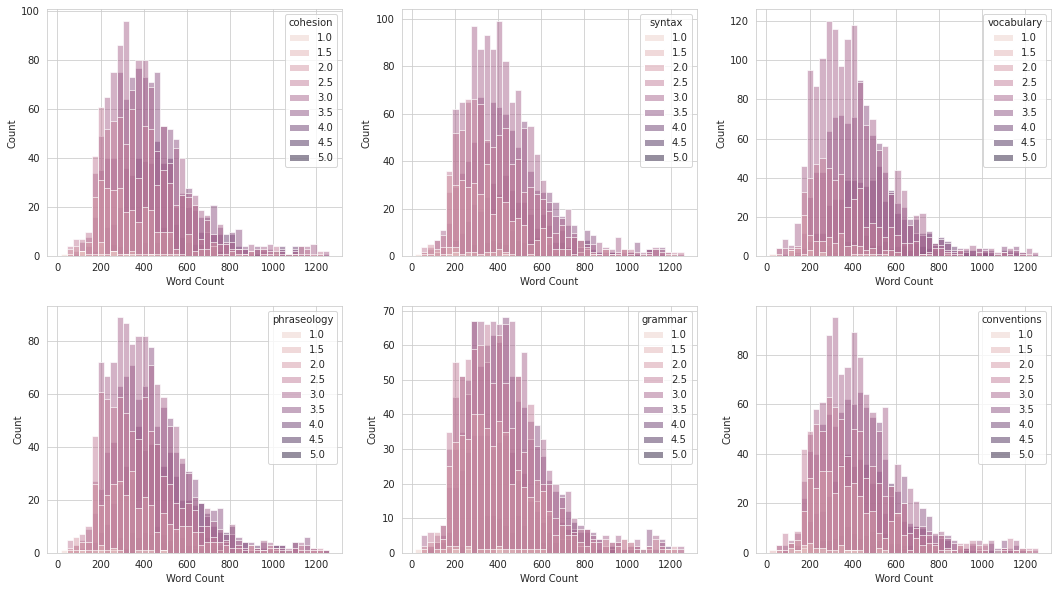

In [17]:
sns.set_style('whitegrid')
plt.figure(figsize=(18,10))
for idx, label in enumerate(target_cols):
    plt.subplot(2, 3, idx+1)
    sns.histplot(x='word_count', hue = label, data = train_df)
    plt.xlabel('Word Count', fontsize=10)

## **Correlation** Study Between Word Count and Metrics

corr_df.columns:
Index(['word_count', 'cohesion', 'syntax', 'vocabulary', 'phraseology',
       'grammar', 'conventions'],
      dtype='object')


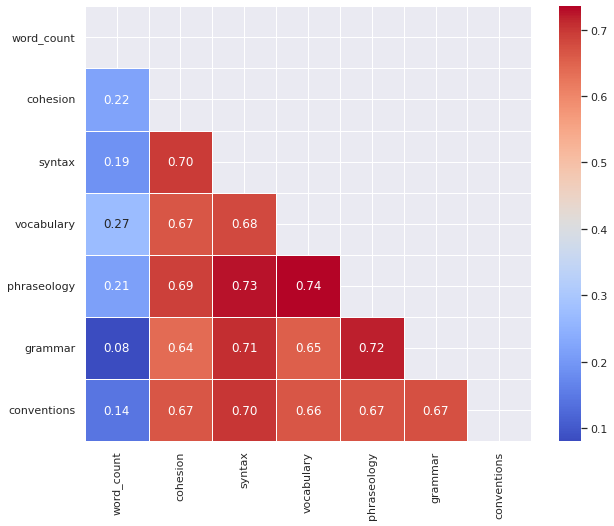

In [18]:
corr_df = train_df[['word_count', 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']].sort_values(by='word_count', ascending=False)

# label_target_cols = corr_df.columns[2:]
print(f'corr_df.columns:\n{corr_df.columns}')
corr = train_df[corr_df.columns].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype = bool))

sns.set(rc = {"figure.figsize": (10, 8)})

sns.heatmap(corr, 
            annot = True, 
            cmap = "coolwarm", 
            mask = mask,
            linewidth=0.5,
            fmt  = ".2f")
plt.show()

There is no strong evidence of relationship between the 6 metrics and word count while vocab scores demo a bit higher assoication with the word count as expected.

## Check Unique Values in Each Metric

In [19]:
print('Unique Values in Each Metric:\n==================================================')
for col in dense_class_cols:
  print(f'{col}: {train_df[col].unique()}')

Unique Values in Each Metric:
cohesion_dense_class: [4 3 5 2 1]
syntax_dense_class: [4 3 5 2 1]
vocabulary_dense_class: [3 5 4 2 1]
phraseology_dense_class: [3 2 5 4 1]
grammar_dense_class: [4 2 3 5 1]
conventions_dense_class: [3 5 4 2 1]


## Check the Shape of Train and Test Set

In [20]:
train_df.shape, test_df.shape

((3911, 24), (3, 2))

## Check Simple Stats/Data Type/Missing Values on Train and Test Set

In [21]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   text_id                   3911 non-null   object 
 1   full_text                 3911 non-null   object 
 2   cohesion                  3911 non-null   float64
 3   syntax                    3911 non-null   float64
 4   vocabulary                3911 non-null   float64
 5   phraseology               3911 non-null   float64
 6   grammar                   3911 non-null   float64
 7   conventions               3911 non-null   float64
 8   word_count                3911 non-null   int64  
 9   char_len                  3911 non-null   int64  
 10  avg_score                 3911 non-null   float64
 11  total_score               3911 non-null   float64
 12  cohesion_sparse_class     3911 non-null   int64  
 13  cohesion_dense_class      3911 non-null   int64  
 14  syntax_s

In [22]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_id    3 non-null      object
 1   full_text  3 non-null      object
dtypes: object(2)
memory usage: 176.0+ bytes


In [23]:
train_df.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,word_count,char_len,avg_score,total_score,...,syntax_sparse_class,syntax_dense_class,vocabulary_sparse_class,vocabulary_dense_class,phraseology_sparse_class,phraseology_dense_class,grammar_sparse_class,grammar_dense_class,conventions_sparse_class,conventions_dense_class
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,...,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053,430.492969,2334.522373,3.102915,18.621836,...,4.056507,3.262848,4.471491,3.448479,4.233700,3.349527,4.065712,3.274354,4.162107,3.315520
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450,191.868449,1033.406009,0.562104,3.365642,...,1.288798,0.703624,1.166297,0.633136,1.311994,0.703880,1.399681,0.763727,1.342901,0.728072
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.000000,82.000000,1.000000,6.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000,294.000000,1597.000000,2.700000,16.000000,...,3.000000,3.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,402.000000,2173.000000,3.100000,18.500000,...,4.000000,3.000000,4.000000,3.000000,4.000000,3.000000,4.000000,3.000000,4.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,526.500000,2866.500000,3.500000,21.000000,...,5.000000,4.000000,5.000000,4.000000,5.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1260.000000,6044.000000,5.000000,30.000000,...,8.000000,5.000000,8.000000,5.000000,8.000000,5.000000,8.000000,5.000000,8.000000,5.000000


## Pull Only the 6 Metrics and Conduct **EDA**

In [24]:
train_df[target_cols].drop_duplicates()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,3.5,3.5,3.0,3.0,4.0,3.0
1,2.5,2.5,3.0,2.0,2.0,2.5
2,3.0,3.5,3.0,3.0,3.0,2.5
3,4.5,4.5,4.5,4.5,4.0,5.0
4,2.5,3.0,3.0,3.0,2.5,2.5
...,...,...,...,...,...,...
3889,3.5,2.5,3.0,2.5,2.5,2.5
3896,2.0,3.0,3.0,2.5,2.0,2.0
3899,3.5,3.5,4.5,3.5,4.0,4.0
3904,2.5,2.0,2.5,1.5,2.0,2.0


In [25]:
train_df[target_cols].value_counts()

cohesion  syntax  vocabulary  phraseology  grammar  conventions
3.0       3.0     3.0         3.0          2.5      3.0            19
3.5       3.5     3.5         3.5          3.5      3.5            17
2.5       2.5     3.0         2.5          2.5      3.0            17
3.0       3.0     3.0         3.0          2.5      2.5            15
2.5       2.5     3.0         3.0          2.5      2.5            15
                                                                   ..
3.0       3.0     3.5         3.5          2.5      2.5             1
                              3.0          4.0      4.0             1
                                           3.0      2.0             1
                                           2.0      2.5             1
5.0       5.0     5.0         5.0          5.0      5.0             1
Length: 1768, dtype: int64

In [26]:
# Essays with at least 97% total score
train_df[train_df[target_cols].sum(axis=1) > 29]

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,word_count,char_len,...,syntax_sparse_class,syntax_dense_class,vocabulary_sparse_class,vocabulary_dense_class,phraseology_sparse_class,phraseology_dense_class,grammar_sparse_class,grammar_dense_class,conventions_sparse_class,conventions_dense_class
258,12E3D52345C6,Technology has always acted as a compelling an...,5.0,5.0,5.0,5.0,4.5,5.0,651,4053,...,8,5,8,5,8,5,7,5,8,5
1082,52DC3B7C3952,Working From Home\n\nShould students be allowe...,5.0,5.0,4.5,5.0,5.0,5.0,508,2745,...,8,5,7,5,8,5,8,5,8,5
2389,B1AFACE6704E,I agree with Michelangelo's statement as I hav...,5.0,5.0,5.0,5.0,5.0,5.0,921,5118,...,8,5,8,5,8,5,8,5,8,5


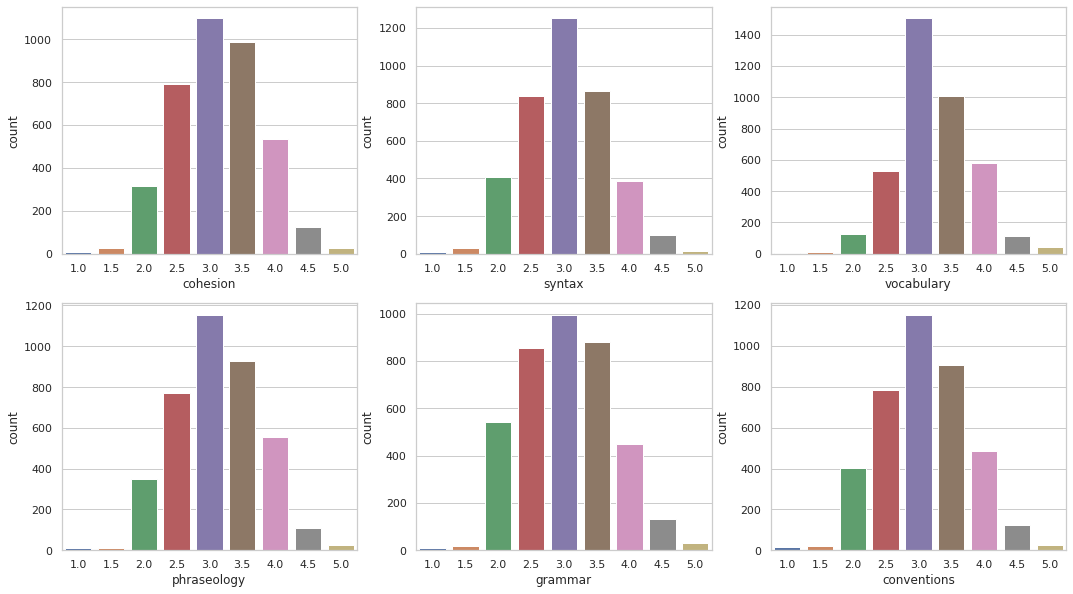

In [27]:
def plot_count(df, labels):
  sns.set_style('whitegrid')
  plt.figure(figsize=(18,10))
  for idx, label in enumerate(labels):
      plt.subplot(2, 3, idx+1)
      sns.countplot(x = label, data = df)

plot_count(train_df, target_cols)

(0.0, 4.0)

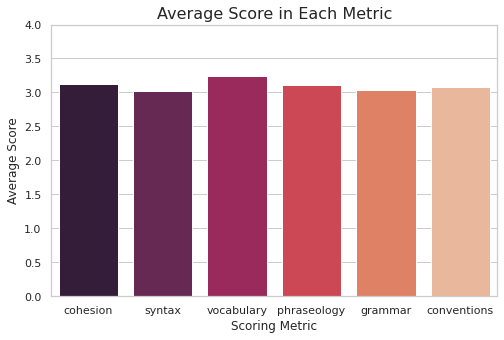

In [28]:
plt.figure(figsize=(8,5))

avg_score = [train_df[label].mean() for label in target_cols]
# print(avg_score)
ax = sns.barplot(x=target_cols, y=avg_score, palette='rocket')
plt.xlabel('Scoring Metric', fontsize=12)
plt.ylabel('Average Score', fontsize=12)
plt.title('Average Score in Each Metric', fontsize=16)
plt.ylim(0, 4)

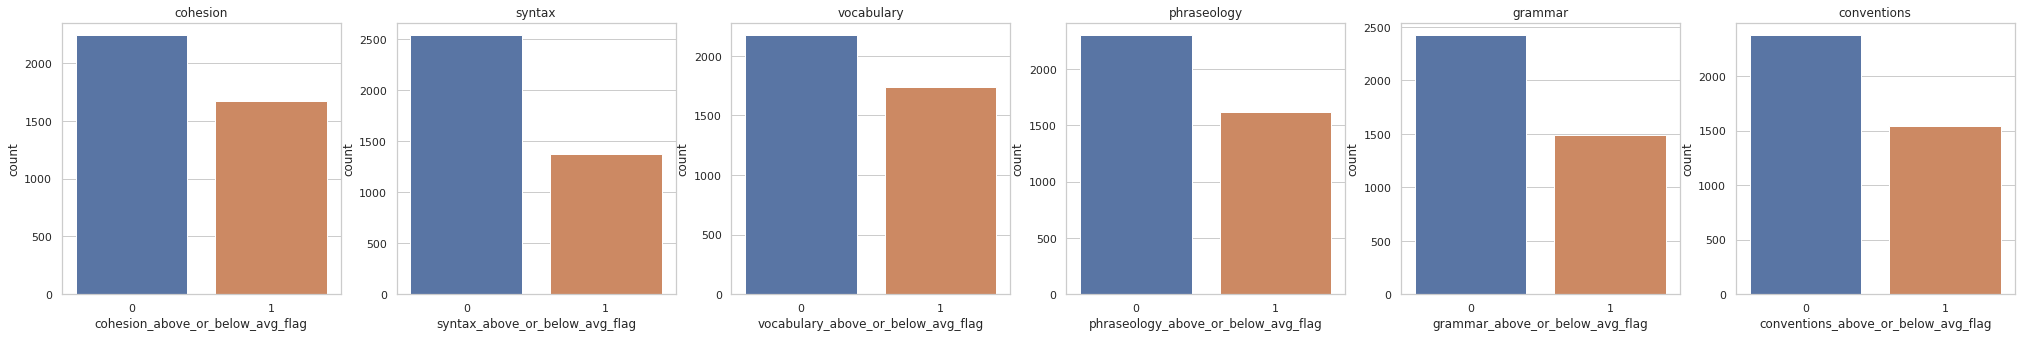

In [29]:
for label in target_cols:
    train_df[label + '_above_or_below_avg_flag'] = np.where(train_df[label] > np.mean(train_df[label]), 1, 0)   # 1 being greater than mean, 0 being lower than mean

fig, ax = plt.subplots(1, len(target_cols), figsize=(35,5))
for idx, label in enumerate(target_cols):
    sns.countplot(x = train_df[label + '_above_or_below_avg_flag'], ax = ax[idx])
    ax[idx].set_title(label)

In [30]:
first_essay = train_df['full_text'][0]
print(f'In the First Essay\n=====================================\nnum_words (tokens) = {len(first_essay.split())}\nnum_characters_in_first_essay = {len(first_essay)}')
print(f'Total score = {round(train_df[target_cols].sum(axis=1)[0])} out of 30\n=====================================')
first_essay

In the First Essay
num_words (tokens) = 261
num_characters_in_first_essay = 1387
Total score = 20 out of 30


"I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.\n\nThe hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.\n\nmost students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up and go t

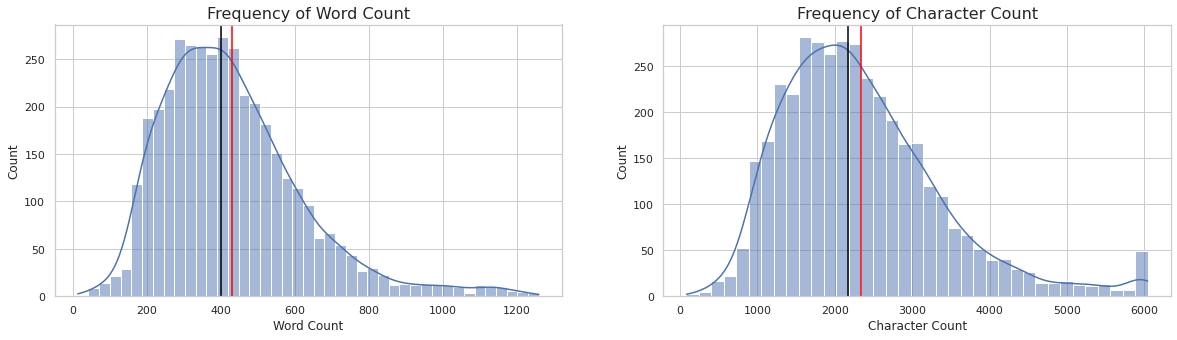

In [31]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.histplot(data=train_df, x='word_count', kde=True)
plt.axvline(x=train_df['word_count'].mean(),color='red')
plt.axvline(x=train_df['word_count'].median(),color='black')
plt.xlabel('Word Count',fontsize=12)
plt.title('Frequency of Word Count',fontsize=16)

plt.subplot(1,2,2)
sns.histplot(data=train_df, x='char_len', kde=True)
plt.axvline(x=train_df['char_len'].mean(),color='red')
plt.axvline(x=train_df['char_len'].median(),color='black')
plt.xlabel('Character Count',fontsize=12)
plt.title('Frequency of Character Count',fontsize=16);

In [32]:
train_df[list(target_cols) + ['word_count', 'char_len']].describe().T

,count,mean,std,min,25%,50%,75%,max
cohesion,3911.0,3.127077,0.662542,1.0,2.5,3.0,3.5,5.0
syntax,3911.0,3.028254,0.644399,1.0,2.5,3.0,3.5,5.0
vocabulary,3911.0,3.235745,0.583148,1.0,3.0,3.0,3.5,5.0
phraseology,3911.0,3.116850,0.655997,1.0,2.5,3.0,3.5,5.0
grammar,3911.0,3.032856,0.699841,1.0,2.5,3.0,3.5,5.0
conventions,3911.0,3.081053,0.671450,1.0,2.5,3.0,3.5,5.0
word_count,3911.0,430.492969,191.868449,14.0,294.0,402.0,526.5,1260.0
char_len,3911.0,2334.522373,1033.406009,82.0,1597.0,2173.0,2866.5,6044.0


## The Most Occurring Words in the Top Essay with Perfect Score 30

Built-in STOPWORDS: {"hasn't", 'did', 'else', 'for', "mustn't", 'from', 'ours', 'she', 'them', 'itself', 'between', 'under', 'i', 'also', 'more', 'up', 'so', 'their', 'could', "can't", "who's", 'than', 'again', 'they', 'we', 'can', 'it', "where's", 'was', 'since', 'but', 'how', 'however', 'nor', 'ought', 'because', 'what', 'through', 'own', 'whom', "he's", "we're", 'doing', "you'll", 'both', 'of', 'you', "it's", 'some', 'below', 'hers', 'its', 'com', "there's", 'http', 'am', "they'd", 'ourselves', 'he', "shouldn't", 'that', "they've", 'shall', 'not', 'until', 'only', 'my', 'is', 'this', 'therefore', 'as', 'an', 'during', 'such', 'to', 'over', 'down', 'does', 'a', "couldn't", 'have', "they'll", "let's", 'out', "you've", 'off', "i'm", "he'd", 'few', 'k', 'her', "aren't", "she's", 'most', 'being', 'been', 'on', 'which', 'be', 'all', 'our', 'further', 'if', 'has', 'why', 'into', 'get', 'very', 'should', 'are', "won't", 'in', 'above', 'those', "she'd", 'after', "don't", "doesn't", 'hence', 

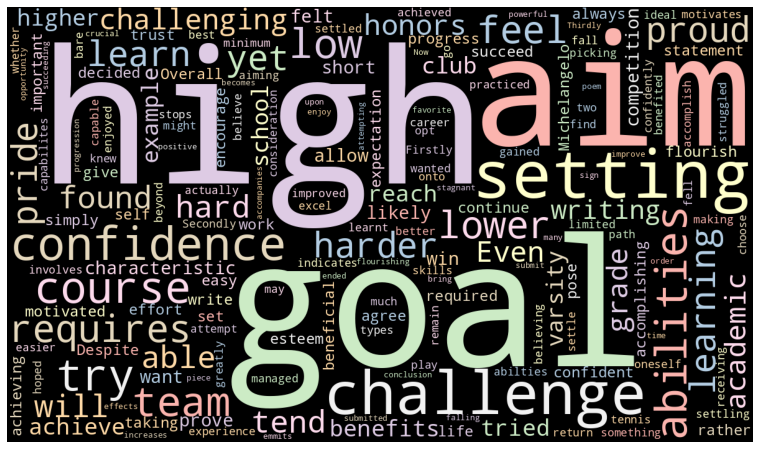

In [33]:
from wordcloud import WordCloud, STOPWORDS
print(f'Built-in STOPWORDS: {STOPWORDS}')

# The most occurring words excluding stopwords
text = train_df[train_df[target_cols].sum(axis=1)==30]['full_text'].values[0]
word_cloud = WordCloud(stopwords=STOPWORDS, colormap='Pastel1', collocations=False, width=1200, height=700, background_color = "black").generate(text)
plt.figure(figsize=(20,8))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# Build a Baseline BERT
1) Build 6 Separate Models with **BERT** and **Multiclass Softmax Classification**<br>
2) Build a Single Model with **BERT** and **Multiclass Softmax Classification** for All 6 Metrics<br>
3) Build 6 Separate Models with **BERT** and **Oridinal Logistic Regression**<br>
4) Build a Single Model with **BERT** and **Oridinal Logistic Regression** for All 6 Metrics

In [34]:
MAX_LENGTH = 500

In [35]:
#make it easier to use a variety of BERT subword models
# model_checkpoint == 'bert-base-cased'    # case sensitive (care about upper and lower case)
model_checkpoint = 'vinai/bertweet-base'   

In [36]:
from transformers import BertTokenizer, TFBertModel, AutoModel, AutoTokenizer

def transformer_tokenizer(model_checkpoint):
  if model_checkpoint == 'bert-base-cased':
    tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
  elif model_checkpoint == "vinai/bertweet-base":
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=False)   ## For transformers v4.x+:
  return tokenizer

tokenizer = transformer_tokenizer(model_checkpoint)

## 80:20 Train and Test Set Split
Instead of 80:10:10 for train/valid/test as not intending to apply hyperparameter tuning.


In [37]:
test_df

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [38]:
df_sparse_class

,cohesion_sparse_class,cohesion_dense_class,syntax_sparse_class,syntax_dense_class,vocabulary_sparse_class,vocabulary_dense_class
0,5,4,5,4,4,3
1,3,3,3,3,4,3
2,4,3,5,4,4,3
3,7,5,7,5,7,5
4,3,3,4,3,4,3
...,...,...,...,...,...,...
3906,3,3,4,3,4,3
3907,6,4,6,4,6,4
3908,3,3,4,3,4,3
3909,6,4,7,5,7,5


In [39]:
df_dense_class

,phraseology_sparse_class,phraseology_dense_class,grammar_sparse_class,grammar_dense_class,conventions_sparse_class,conventions_dense_class
0,4,3,6,4,4,3
1,2,2,2,2,3,3
2,4,3,4,3,3,3
3,7,5,6,4,8,5
4,4,3,3,3,3,3
...,...,...,...,...,...,...
3906,5,4,3,3,3,3
3907,6,4,5,4,4,3
3908,4,3,5,4,4,3
3909,6,4,7,5,7,5


In [60]:
x = train_df['full_text']
y_sparse = train_df[sparse_class_cols]
y_dense = train_df[dense_class_cols]

x_train_sparse, x_test_sparse, y_train_sparse, y_test_sparse = train_test_split(x, y_sparse, train_size=0.8, random_state=42) 
x_train_dense, x_test_dense, y_train_dense, y_test_dense = train_test_split(x, y_dense, train_size=0.8, random_state=42) 
print(f'len(x_train_sparse) = {len(x_train_sparse)}\nlen(x_test_sparse) = {len(x_test_sparse)}')
print(f'\nlen(x_train_dense) = {len(x_train_dense)}\nlen(x_test_dense) = {len(x_test_dense)}')

# ========== OLD CODE ====================
# x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size=0.8, random_state=42)      # random_state: for reproducible output across multiple function calls
# x_test = test_df['full_text']
# print(f'len(x_train) = {len(x_train)}\nlen(x_valid) = {len(x_valid)}\nlen(x_test) = {len(x_test)}')

len(x_train_sparse) = 3128
len(x_test_sparse) = 783

len(x_train_dense) = 3128
len(x_test_dense) = 783


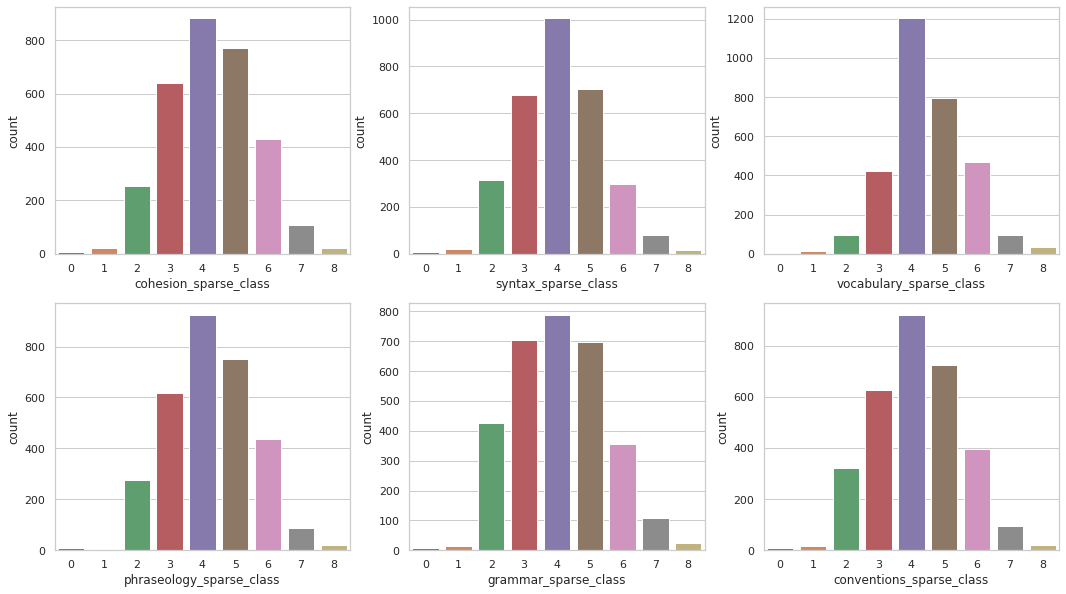

In [61]:
plot_count(y_train_sparse, sparse_class_cols)

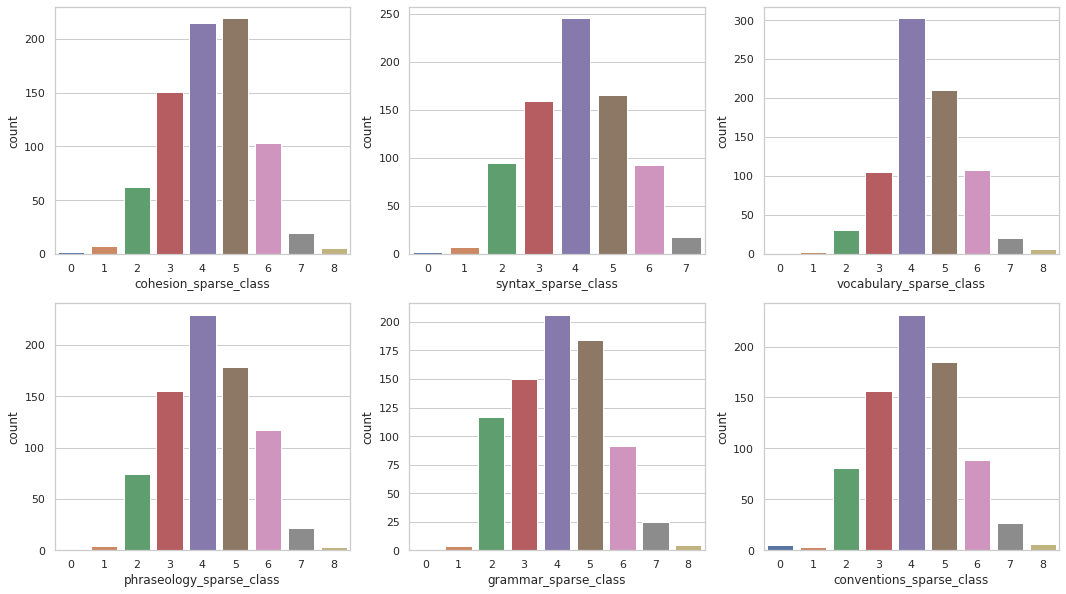

In [62]:
plot_count(y_test_sparse, sparse_class_cols)

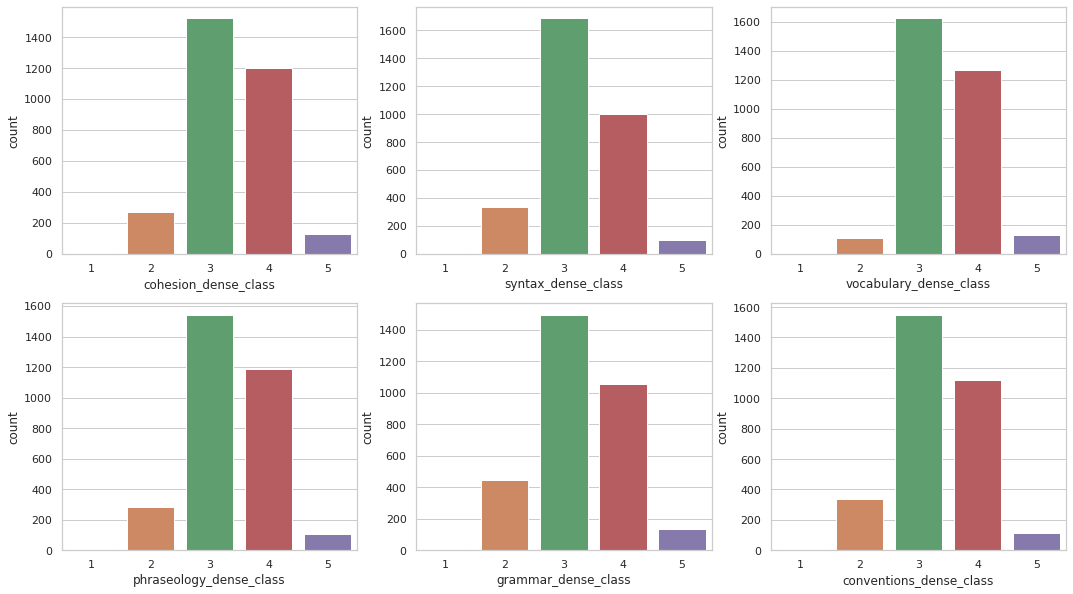

In [64]:
plot_count(y_train_dense, dense_class_cols)

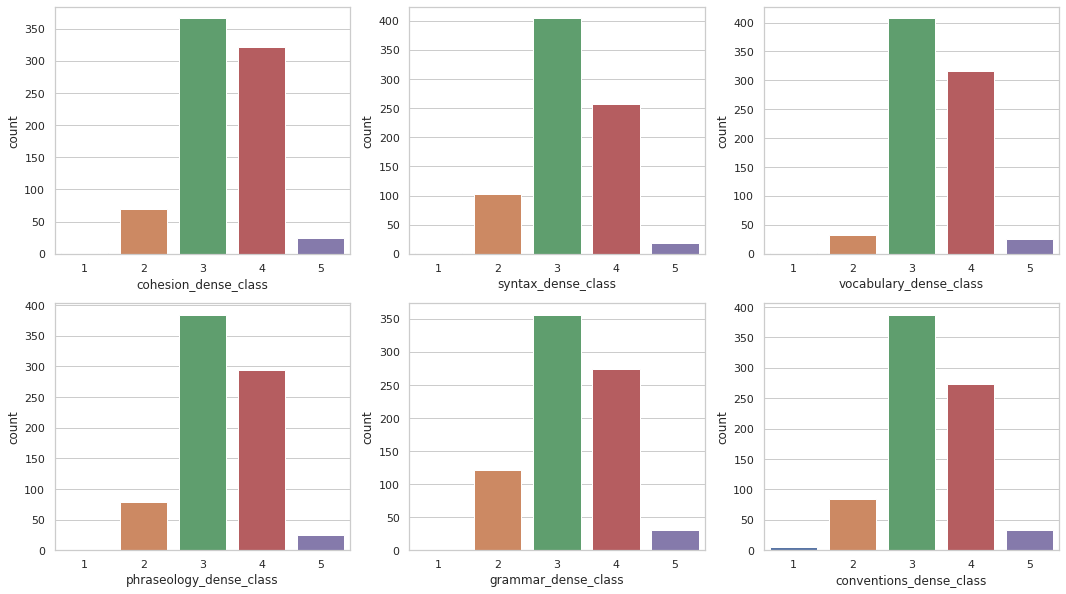

In [63]:
plot_count(y_test_dense, dense_class_cols)

In [44]:
sparse_class_cols

['cohesion_sparse_class',
 'syntax_sparse_class',
 'vocabulary_sparse_class',
 'phraseology_sparse_class',
 'grammar_sparse_class',
 'conventions_sparse_class']

In [45]:
dense_class_cols

['cohesion_dense_class',
 'syntax_dense_class',
 'vocabulary_dense_class',
 'phraseology_dense_class',
 'grammar_dense_class',
 'conventions_dense_class']

In [65]:
# df_dense_class.info()

In [66]:
# df_sparse_class.info()

In [67]:
# df_sparse_class.head(2)
# print(train_df.columns)
# train_df.iloc[:2, 2:9]

- **x_train** - a list of text strings for training
- **x_test** - a list of text strings for testing
- **x_valid** - a list of text strings for validation
- **y_train** - an array of float score representing the labels associated with x_train texts
- **y_test** - an array of float score representing the labels associated with x_test texts
- **y_valid** - an array of float score representing the labels associated with x_valid texts
- **y_train_labels** - a list of float labels of all 6 metrics for training
- **y_valid_labels** - a list of float labels of all 6 metrics for validation

## Generate **Input Embeddings** - Train/Validation/Test Set

In [70]:
train_encodings_sparse = tokenizer(x_train_sparse.tolist(), truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')
test_encodings_sparse = tokenizer(x_test_sparse.tolist(), truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')
# valid_encodings = tokenizer(x_valid.tolist(), truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')

In [71]:
train_encodings_sparse

{'input_ids': <tf.Tensor: shape=(3128, 500), dtype=int32, numpy=
array([[    0, 59225,    14, ...,     1,     1,     1],
       [    0,   326,    17, ...,    72,   202,     2],
       [    0, 45437, 25582, ...,     1,     1,     1],
       ...,
       [    0, 57418,    41, ..., 27466,  1911,     2],
       [    0,  4267, 13824, ...,    30,    44,     2],
       [    0,   122,  1724, ...,     1,     1,     1]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(3128, 500), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(3128, 500), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

In [72]:
print(y_test_sparse.columns)
print(y_test_dense.columns)

Index(['cohesion_sparse_class', 'syntax_sparse_class',
       'vocabulary_sparse_class', 'phraseology_sparse_class',
       'grammar_sparse_class', 'conventions_sparse_class'],
      dtype='object')
Index(['cohesion_dense_class', 'syntax_dense_class', 'vocabulary_dense_class',
       'phraseology_dense_class', 'grammar_dense_class',
       'conventions_dense_class'],
      dtype='object')


## Generate **Target Labels** for 6 Separate Models

In [74]:
y_train_cohesion_sparse = np.array(y_train_sparse['cohesion_sparse_class'])
y_train_syntax_sparse = np.array(y_train_sparse['syntax_sparse_class'])
y_train_vocabulary_sparse = np.array(y_train_sparse['vocabulary_sparse_class'])
y_train_phraseology_sparse = np.array(y_train_sparse['phraseology_sparse_class'])
y_train_grammar_sparse = np.array(y_train_sparse['grammar_sparse_class'])
y_train_conventions_sparse = np.array(y_train_sparse['conventions_sparse_class'])
y_train_separate_labels_sparse = [y_train_cohesion_sparse, y_train_syntax_sparse, y_train_vocabulary_sparse, y_train_phraseology_sparse, y_train_grammar_sparse, y_train_conventions_sparse]

y_test_cohesion_sparse = np.array(y_test_sparse['cohesion_sparse_class'])
y_test_syntax_sparse = np.array(y_test_sparse['syntax_sparse_class'])
y_test_vocabulary_sparse = np.array(y_test_sparse['vocabulary_sparse_class'])
y_test_phraseology_sparse = np.array(y_test_sparse['phraseology_sparse_class'])
y_test_grammar_sparse = np.array(y_test_sparse['grammar_sparse_class'])
y_test_conventions_sparse = np.array(y_test_sparse['conventions_sparse_class'])
y_test_separate_labels_sparse = [y_test_cohesion_sparse, y_test_syntax_sparse, y_test_vocabulary_sparse, y_test_phraseology_sparse, y_test_grammar_sparse, y_test_conventions_sparse]

print(len(y_train_conventions_sparse))
y_train_conventions_sparse

3128


array([5, 4, 3, ..., 3, 5, 3])

## Generate **Target Labels** for a single Model for All 6 Metrics

In [77]:
def create_labels_for_single_model():
  y_train_labels_sparse, y_test_labels_sparse = [], []
  for i in range(len(y_train_cohesion_sparse)):
    y_train_labels_sparse.append([y_train_cohesion_sparse[i], y_train_syntax_sparse[i], y_train_vocabulary_sparse[i], y_train_phraseology_sparse[i], y_train_grammar_sparse[i], y_train_conventions_sparse[i]])
  for i in range(len(y_test_cohesion_sparse)):
    y_test_labels_sparse.append([y_test_cohesion_sparse[i], y_test_syntax_sparse[i], y_test_vocabulary_sparse[i], y_test_phraseology_sparse[i], y_test_grammar_sparse[i], y_test_conventions_sparse[i]])

  return np.array(y_train_labels_sparse), np.array(y_test_labels_sparse)  

y_train_single_labels_sparse, y_test_single_labels_sparse = create_labels_for_single_model()
print(y_train_single_labels_sparse.shape)
y_train_single_labels_sparse[:5]

(3128, 6)


array([[6, 5, 4, 5, 6, 5],
       [5, 6, 5, 5, 3, 4],
       [2, 3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4, 3],
       [3, 3, 3, 2, 3, 3]])

## 1) Build 6 Separate Models with BERT and Multiclass Softmax Classification

In [78]:
def create_6_separate_baseline_models(checkpoint = model_checkpoint,
                        num_classes=9,   # [1, 1.5, 2, 2.5....4.5, 5]: 9 classes
                        # num_train_layers=0,
                        num_train_layers=12,
                        hidden_size=256,
                        dropout=0.3,
                        learning_rate=0.00005,
                        max_length=MAX_LENGTH):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    # =========== BEGIN generate "input features" using BERT tokenizer ==================================
    bert_model = TFBertModel.from_pretrained(checkpoint)    
    if num_train_layers == 0:
        bert_model.trainable = False                 # Freeze all layers of pre-trained BERT model

    elif num_train_layers == 12:         
        bert_model.trainable = True                  # Train all layers of the BERT model

    else:                                            # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []
        for retrain_layer_number in range(num_train_layers):
            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code) 
        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    # Input layer
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}
                   
    # Bert output: being used as an input feature in the classification model below
    bert_out = bert_model(bert_inputs)        # full features as an input to the following classification model
    # pooler_output = bert_out[1]             # one vector for each
    cls_token = bert_out[0][:, 0, :]          # give us a raw CLS tokens

    # =========== END generate "input features" using BERT tokenizer ==================================

    # =========== BEGIN build a "multi-classification model" below passing the BERT input features ======
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    # Output classification layer
    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    # =========== END build a "multi-classification model" below passing the BERT input features ======
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),   # expect integer-type labels
                                 metrics='accuracy')                 
    return classification_model

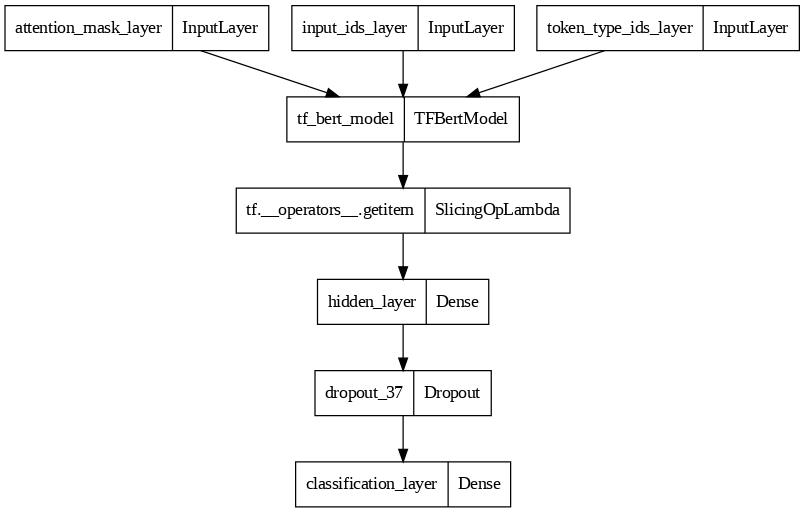

In [79]:
bert_6_separate_model = create_6_separate_baseline_models()
keras.utils.plot_model(bert_6_separate_model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

In [80]:
bert_6_separate_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 500)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                              

## Train 6 Individual Model for Each Proficiency Metric and Predict Scores for Test Set

In [87]:
print(y_train_separate_labels_sparse[0][:10])   # looks distributed properly

[6 5 2 4 3 3 4 4 4 3]


In [88]:
def train_separate_model_for_each_metrics(y_train_labels, y_test_labels, target_cols, epochs=1):
  models = []
  # for i in range(len(y_train_labels)):
  # for i in range(len(y_train_labels[0])):
  baseline_6_separate_model = create_6_separate_baseline_models()

  print(f'Train BERT for {target_cols[i].title()}........')
  class_weights = {}
  baseline_6_separate_model_history = baseline_6_separate_model.fit([train_encodings_sparse.input_ids, train_encodings_sparse.token_type_ids, train_encodings_sparse.attention_mask], 
                                                                    y_train_separate_labels_sparse[i],   
                                                                    validation_data=([test_encodings_sparse.input_ids, test_encodings_sparse.token_type_ids, test_encodings_sparse.attention_mask], 
                                                                                      y_test_separate_labels_sparse[i]),    
                                                                    batch_size=8, 
                                                                    epochs=epochs,
                                                                    class_weights=class_weights) 
  
  # Predict Scores for Test Set
  prediction_base_BERT = baseline_6_separate_model.predict([test_encodings_sparse.input_ids, test_encodings_sparse.token_type_ids, test_encodings_sparse.attention_mask])
  prediction_base_BERT = tf.argmax(prediction_base_BERT, axis=-1)
  print(f'Prediction Scores For {target_cols[i].title()}: {prediction_base_BERT}\n')

  models.append(baseline_6_separate_model)
  return models

In [89]:
train_separate_model_for_each_metrics(y_train_separate_labels_sparse, y_test_separate_labels_sparse, sparse_class_cols, epochs=3)
# out of memory issue running 6 models. free up resources every time you run each model
# save to my file system model checkpoint. load it from the checkpoint
# get it work for one class at a time 

Train BERT for Cohesion_Sparse_Class........


TypeError: ignored

In [ ]:
# train_separate_model_for_each_metrics(y_train_separate_labels, y_valid_separate_labels, cat_target_cols, epochs=3)

## Evaluation
ISSUE: We have **NO true test labels** labels for the test set to compare and generate the evaluation metrics i.e. precision, f1 score, etc

[linear regression with BERT and MSE](https://medium.com/ilb-labs-publications/fine-tuning-bert-for-a-regression-task-is-a-description-enough-to-predict-a-propertys-list-price-cf97cd7cb98a)<br>
[MSE](https://www.kaggle.com/code/mrscofield/feedback-prize-english-universal-sentence-encoder)<br>
[multi-label multiclass](https://stackoverflow.com/questions/54893341/multiple-softmax-classifications-keras)



In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(test_labels, prediction_base_BERT.numpy(), target_names = target_names, digits=5))

In [ ]:
target_cols
# cat_target_cols 

['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

In [ ]:
def create_single_baseline_model_for_all_6_metrics(checkpoint = model_checkpoint,
                                                  num_classes=9,   # [1, 1.5, 2, 2.5....4.5, 5]: 9 classes
                                                  # num_train_layers=0,
                                                  num_train_layers=12,
                                                  hidden_size=201,
                                                  dropout=0.3,
                                                  learning_rate=0.00005,
                                                  max_length=MAX_LENGTH):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    # =========== BEGIN generate "input features" using BERT tokenizer ==================================
    bert_model = TFBertModel.from_pretrained(checkpoint)    
    if num_train_layers == 0:
        bert_model.trainable = False                 # Freeze all layers of pre-trained BERT model

    elif num_train_layers == 12:         
        bert_model.trainable = True                  # Train all layers of the BERT model

    else:                                            # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []
        for retrain_layer_number in range(num_train_layers):
            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code) 
        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    # Input layer
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}
                   
    # Bert output: being used as an input feature in the classification model below
    bert_out = bert_model(bert_inputs)        # full features as an input to the following classification model
    # pooler_output = bert_out[1]             # one vector for each
    cls_token = bert_out[0][:, 0, :]          # give us a raw CLS tokens

    # =========== END generate "input features" using BERT tokenizer ==================================

    # =========== BEGIN build a "multi-classification model" below passing the BERT input features ======
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    # Output 6 separate classification layers (multi-head)
    # classification_cohesion = tf.keras.layers.Dense(num_classes, activation='softmax',name='cohesion_layer')(hidden) 
    # classification_syntax = tf.keras.layers.Dense(num_classes, activation='softmax',name='syntax_layer')(hidden)
    # classification_vocabulary = tf.keras.layers.Dense(num_classes, activation='softmax',name='vocabulary_layer')(hidden)
    # classification_phraseology = tf.keras.layers.Dense(num_classes, activation='softmax',name='phraseology_layer')(hidden)
    # classification_grammar = tf.keras.layers.Dense(num_classes, activation='softmax',name='grammar_layer')(hidden)
    # classification_conventions = tf.keras.layers.Dense(num_classes, activation='softmax',name='conventions_layer')(hidden)

    # add more layers here
    classification_cohesion = tf.keras.layers.Dense(num_classes, activation='softmax',name='cohesion_layer')(tf.keras.layers.Dense(20, activation='relu')(hidden))
    classification_syntax = tf.keras.layers.Dense(num_classes, activation='softmax',name='syntax_layer')(tf.keras.layers.Dense(20, activation='relu')(hidden)
    classification_vocabulary = tf.keras.layers.Dense(num_classes, activation='softmax',name='vocabulary_layer')(tf.keras.layers.Dense(20, activation='relu')(hidden)
    classification_phraseology = tf.keras.layers.Dense(num_classes, activation='softmax',name='phraseology_layer')(tf.keras.layers.Dense(20, activation='relu')(hidden)
    classification_grammar = tf.keras.layers.Dense(num_classes, activation='softmax',name='grammar_layer')(tf.keras.layers.Dense(20, activation='relu')(hidden)
    classification_conventions = tf.keras.layers.Dense(num_classes, activation='softmax',name='conventions_layer')(tf.keras.layers.Dense(20, activation='relu')(hidden)

    outputs = [classification_cohesion, classification_syntax, classification_vocabulary, classification_phraseology, classification_grammar, classification_conventions]
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=outputs)
    # =========== END build a "multi-classification model" below passing the BERT input features ======
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss = [tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) for _ in range(6)],
                                #  metrics = ['accuracy' for _ in range(6)])
                                #  metrics = [tf.keras.metrics.Accuracy(name=cls_name) for cls_name in target_cols])
                                 metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name=cls_name) for cls_name in target_cols])
                                #  metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name=str(rank)) for rank in range(num_classes)])
    return classification_model

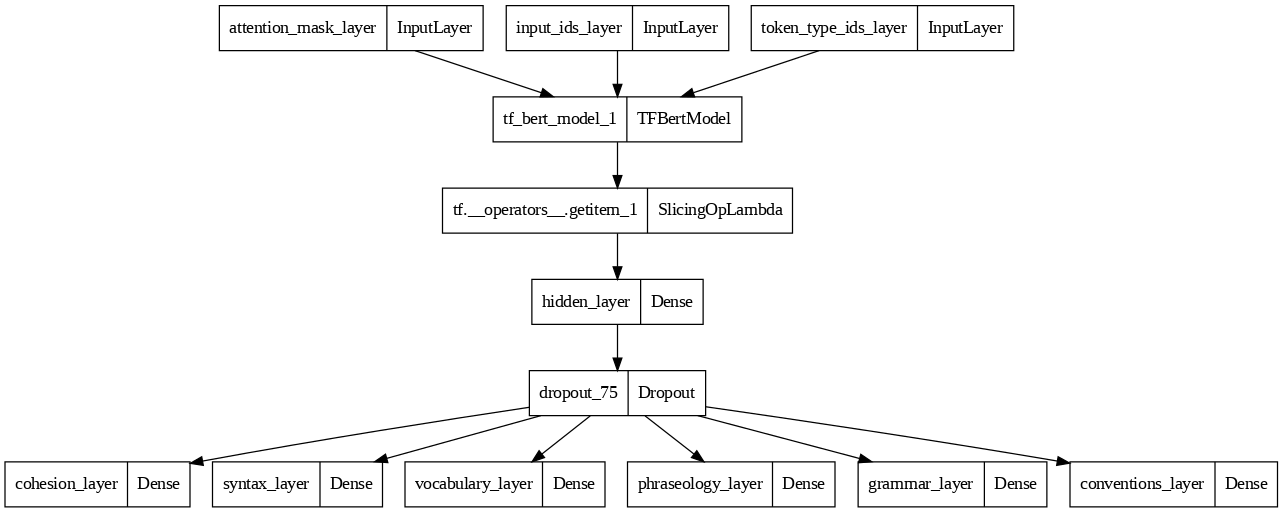

In [ ]:
baseline_bert_single_model = create_single_baseline_model_for_all_6_metrics()
keras.utils.plot_model(baseline_bert_single_model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

In [ ]:
baseline_bert_single_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 500)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                            

In [ ]:
classification_layers = ['cohesion_layer', 'syntax_layer', 'vocabulary_layer', 'phraseology_layer', 'grammar_layer', 'conventions_layer']
train_target_labels = [y_train_cohesion, y_train_syntax, y_train_vocabulary, y_train_phraseology, y_train_grammar, y_train_conventions]
valid_target_labels = [y_valid_cohesion, y_valid_syntax, y_valid_vocabulary, y_valid_phraseology, y_valid_grammar, y_valid_conventions]

dict_y_train_labels = dict(zip(classification_layers, train_target_labels))
dict_y_valid_labels = dict(zip(classification_layers, valid_target_labels))
print(dict_y_train_labels)

{'cohesion_layer': array([6, 5, 2, ..., 3, 5, 3]), 'syntax_layer': array([5, 6, 3, ..., 4, 6, 2]), 'vocabulary_layer': array([4, 5, 3, ..., 4, 5, 3]), 'phraseology_layer': array([5, 5, 3, ..., 4, 5, 2]), 'grammar_layer': array([6, 3, 3, ..., 2, 4, 2]), 'conventions_layer': array([5, 4, 3, ..., 3, 5, 3])}


In [ ]:
baseline_bert_single_model_history = baseline_bert_single_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                                    dict_y_train_labels,   
                                                                    validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
                                                                      dict_y_valid_labels),    
                                                                    batch_size=8, 
                                                                    epochs=10)

Epoch 1/10


391/391 [==============================] - 461s 1s/step - loss: 10.6876 - cohesion_layer_loss: 1.8568 - syntax_layer_loss: 1.7400 - vocabulary_layer_loss: 1.6811 - phraseology_layer_loss: 1.8083 - grammar_layer_loss: 1.8425 - conventions_layer_loss: 1.7589 - cohesion_layer_cohesion: 0.2653 - cohesion_layer_syntax: 0.2653 - cohesion_layer_vocabulary: 0.2653 - cohesion_layer_phraseology: 0.2653 - cohesion_layer_grammar: 0.2653 - cohesion_layer_conventions: 0.2653 - syntax_layer_cohesion: 0.3149 - syntax_layer_syntax: 0.3149 - syntax_layer_vocabulary: 0.3149 - syntax_layer_phraseology: 0.3149 - syntax_layer_grammar: 0.3149 - syntax_layer_conventions: 0.3149 - vocabulary_layer_cohesion: 0.3501 - vocabulary_layer_syntax: 0.3501 - vocabulary_layer_vocabulary: 0.3501 - vocabulary_layer_phraseology: 0.3501 - vocabulary_layer_grammar: 0.3501 - vocabulary_layer_conventions: 0.3501 - phraseology_layer_cohesion: 0.3034 - phraseology_layer_syntax: 0.3034 - phraseology_layer_vocabulary: 0.3034 - phr

In [ ]:
prediction_single_model = baseline_bert_single_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
prediction_single_model = tf.argmax(prediction_single_model, axis=-1)

for i in range(len(target_cols)):
  print(f'Prediction Score For {cat_target_cols[i]}: {prediction_single_model[i]}')

1/1 [==============================] - 4s 4s/step
Prediction Score For cat_cohesion: [4 4 5]
Prediction Score For cat_syntax: [4 3 5]
Prediction Score For cat_vocabulary: [4 3 5]
Prediction Score For cat_phraseology: [3 3 4]
Prediction Score For cat_grammar: [4 2 5]
Prediction Score For cat_conventions: [3 4 4]


## [Debugging ML Models and Error Analysis](https://www.youtube.com/watch?v=ORrStCArmP4)
In developing learning algorithms, the most common diagnostics that Andrew Ng used is **bias-variance diagostic**, understanding how much of the problem in your learning algorithm comes from bias and how much of it comes from variance. If the bias-variance diagostic with a classifier is **highly biased (high error on both test and train data)** then it tends to **underfit the data**. **High variance classifiers (high error on test data and low error on train data - starts modeling the noise in the input)** may be much too complex so it tends to **overfit the data**. So with trade-off bias and variance in an appropriate way would be ideal.

- **Bias**: Error between average model prediction and ground truth.
- **Variance**: Average variability in the model prediction for the given dataset.
  - The variance of the estimated function tells you how much the function can adjust to the change in the dataset.
- **Bias Variance Trade-off**: 
  - Increasing bias (not always) reduces variance and vice-versa
  - $Error = bias^2 + variance + irreducible error$
  - The best model is where the error is reduced.
  - Compromise between bias and variance.